# Extended Kalman Filter localization example
We are considering a robot with differential traction with a rotary sensor on its top. It detects beacons and obtain a measure of its distance and angle to the robot refential frame.
Whenever we observe a beacon there is an error in the estimated angle and an error in estimating the distance. We assume that the standard deviation of the distance error increases proportionally with distance.

This work is inspired on "Laboratorial Work 4 - Robot localization based on beacons" from the course "Sistemas Robóticos Autónomos" at FEUP.
More specifically we are talking about a soccer robot in a small soccer field with the beacons in the four corner. The robot uses first a rotative of a camera and then an omnidirectional camera in the second part. 

## 1. Extended Kalman Filter implementation in robot simulator
We start by importing numpy

In [34]:
import numpy as np

and setting the initial state of the robot at

In [35]:
x = np.array([2, -2, 0])

Differently from MATLAB at this stage does not make sense to distinguish from "horizontal" or "vertical" vectors.

We are going to simulate

In [36]:
N = 300

time intervals, each of lenght

In [37]:
dt = 0.040

Now we generate the control signals of the robot for each time interval

In [38]:
v_t = np.random.normal(0,1,N) + 1 #linear velocity
omega_t = np.random.normal(0,1,N)*0.5 + 0.5 #angular velocity

and we group them in

In [39]:
u_t = np.array([v_t,omega_t])

We set the matrices of covariances...

In [40]:
P = np.eye(3)*1e-3 # covariance robot belief from prediction update
Q = np.array([[0.1**2, 0], [0, 0.05**2]]) # covariance belief exteroceptive measurments

Standard deviation of the error of measurment for the beacons

In [41]:
sdv_dist_1m = 0.05
sdv_ang = 0.01

We set the location of the first two beacons in the map

In [42]:
xb1 = 5
yb1 = -2.5
xb2 = 5
yb2 = 2.5

The initial value for the extimated/predicted state/position of the robot is

In [43]:
x_e = np.array([2.5, -2.5, 0])

Initialize to zeros the variables to record the simulation 

In [44]:
x_t = np.zeros([N, 3])
x_e_t = np.zeros([N, 3])

### Simulation

What's this?
TODO: add a cool latex equation here representing the multi-line comment below

In [12]:
from math import sin, cos, sqrt, atan2
def F(t,y,u):
    '''
    Simulation of a mobile robot
    State vector:   X(t)=[displacement along x axis - x(t)
                          displacement along y axis - y(t)
                          angular position - a(t)]
                          
                    u(t)=[linear velocity - v(t)
                          angular velocity - w(t)]
    Equations: dx(t)/dt = v(t)*cos(a(t))
               dy(t)/dt = v(t)*sin(a(t))
               da(t)/dt = w(t)
    '''
    # return dy/dt = f(t,y).
    return np.array([u[0]*cos(y[2]), u[0]*sin(y[2]), u[1]])

In the simulation we need to solve a differential equation, so we will need

In [45]:
from scipy.integrate import solve_ivp

Initialize counter to change from one beacon to the other

In [46]:
p_count = 0

We can start the simulation

In [47]:
for i in range(0, N):
    # record the evolution of the states
    x_t[i] = np.copy(x)
    x_e_t[i] = np.copy(x_e)
    
    # simulation of the robot
    v = u_t[0, i]
    omega = u_t[1, i]
    TSPAN = [0, dt]
    sol = solve_ivp(lambda t, y: F(t,y,u_t[:,i]), TSPAN, x)

    x = sol.y[:,-1]
    xr = x[0]
    yr = x[1]
    theta_r = x[2]

    # update of the extimation of the state of the robot X(k+1) = f(X(k),U)
    xr_e = x_e[0] 
    yr_e = x_e[1] 
    theta_r_e = x_e[2]

    xr_e = xr_e + v * cos(theta_r_e + omega * dt / 2) * dt 
    yr_e = yr_e + v * sin(theta_r_e + omega * dt / 2) * dt 
    theta_r_e = theta_r_e + omega * dt

    x_e = np.array([xr_e, yr_e, theta_r_e])

    # calculate grad_f_X=df/dX 
    grad_f_X = np.array([[1, 0, -v*dt*sin(theta_r_e+omega*dt/2)],
                         [0, 1, v*dt*cos(theta_r_e+omega*dt/2)],
                         [0, 0, 1]])

    # calculate grad_f_U=df/dU
    grad_f_U = np.array([[cos(theta_r_e+omega*dt/2)*dt, -v*dt*0.5*sin(theta_r_e+omega*dt/2)],
                         [sin(theta_r_e+omega*dt/2)*dt, v*dt*0.5*cos(theta_r_e+omega*dt/2)],
                         [0, 1]])

    # update covariance
    P = np.dot(grad_f_X, np.dot(P, grad_f_X.T)) + np.dot(grad_f_U, np.dot(Q, grad_f_U.T))

    # counter to change from one beacon to the other
    p_count += 1

    if p_count==100:
        p_count=0 

    if p_count <= 50: # beacon 1
        # simulation of the observed measures
        distp = sqrt((xb1 - xr)**2 + (yb1 - yr)**2)
        distp_measured = distp + np.random.normal(0,1) * sdv_dist_1m * distp
        theta_p = atan2(yb1 - yr, xb1 - xr) - theta_r
        theta_p_measured = theta_p + np.random.normal(0,1) * sdv_ang
        z = np.array([distp_measured, theta_p_measured])

        # expected values for the measures taking into account the state of the robot z = h(X)
        distp_e = sqrt((xb1 - xr_e)**2 + (yb1 - yr_e)**2)
        theta_p_e = atan2(yb1 - yr_e, xb1 - xr_e) - theta_r_e
        z_e = np.array([distp_e, theta_p_e])

        # covariance matrix of the measures noise
        R = np.array([[(distp_e*sdv_dist_1m)**2, 0],
                      [0, sdv_ang**2]])

        # calculation of dH/dX
        grad_h_X  = np.array([[-(xb1-xr_e)/distp_e, -(yb1-yr_e)/distp_e, 0],
                              [(yb1-yr_e)/(distp_e**2), -(xb1-xr_e)/(distp_e**2), -1]])           
    else: # beacon 2
        # simulation of the observed measures
        distp = sqrt((xb2 - xr)**2 + (yb2 - yr)**2)
        distp_measured = distp + np.random.normal(0,1) * sdv_dist_1m * distp
        theta_p = atan2(yb2 - yr, xb2 - xr) - theta_r
        theta_p_measured = theta_p + np.random.normal(0,1) * sdv_ang
        z = np.array([distp_measured, theta_p_measured])

        # expected values for the measures taking into account the state of the robot z = h(X)
        distp_e = sqrt((xb2 - xr_e)**2 + (yb2 - yr_e)**2)
        theta_p_e = atan2(yb2 - yr_e, xb2 - xr_e) - theta_r_e
        z_e = np.array([distp_e, theta_p_e])

        # covariance matrix of the measures noise
        R = np.array([[(distp_e*sdv_dist_1m)**2, 0],
                      [0, sdv_ang**2]])

        # calculation of dH/dX
        grad_h_X  = np.array([[-(xb2-xr_e)/distp_e, -(yb2-yr_e)/distp_e, 0],
                              [(yb2-yr_e)/(distp_e**2), -(xb2-xr_e)/(distp_e**2), -1]])


    # Kalman gain
    k = np.dot(P,np.dot(grad_h_X.T, np.linalg.inv(np.dot(grad_h_X, np.dot(P, grad_h_X.T)) + R)));

    # covariance update
    P = np.dot(np.eye(3) - np.dot(k, grad_h_X), P)

    # update expected state
    x_e = x_e + np.dot(k, np.transpose(z - z_e))

### Visualize the results
Let's see what we got...

<IPython.core.display.Javascript object>


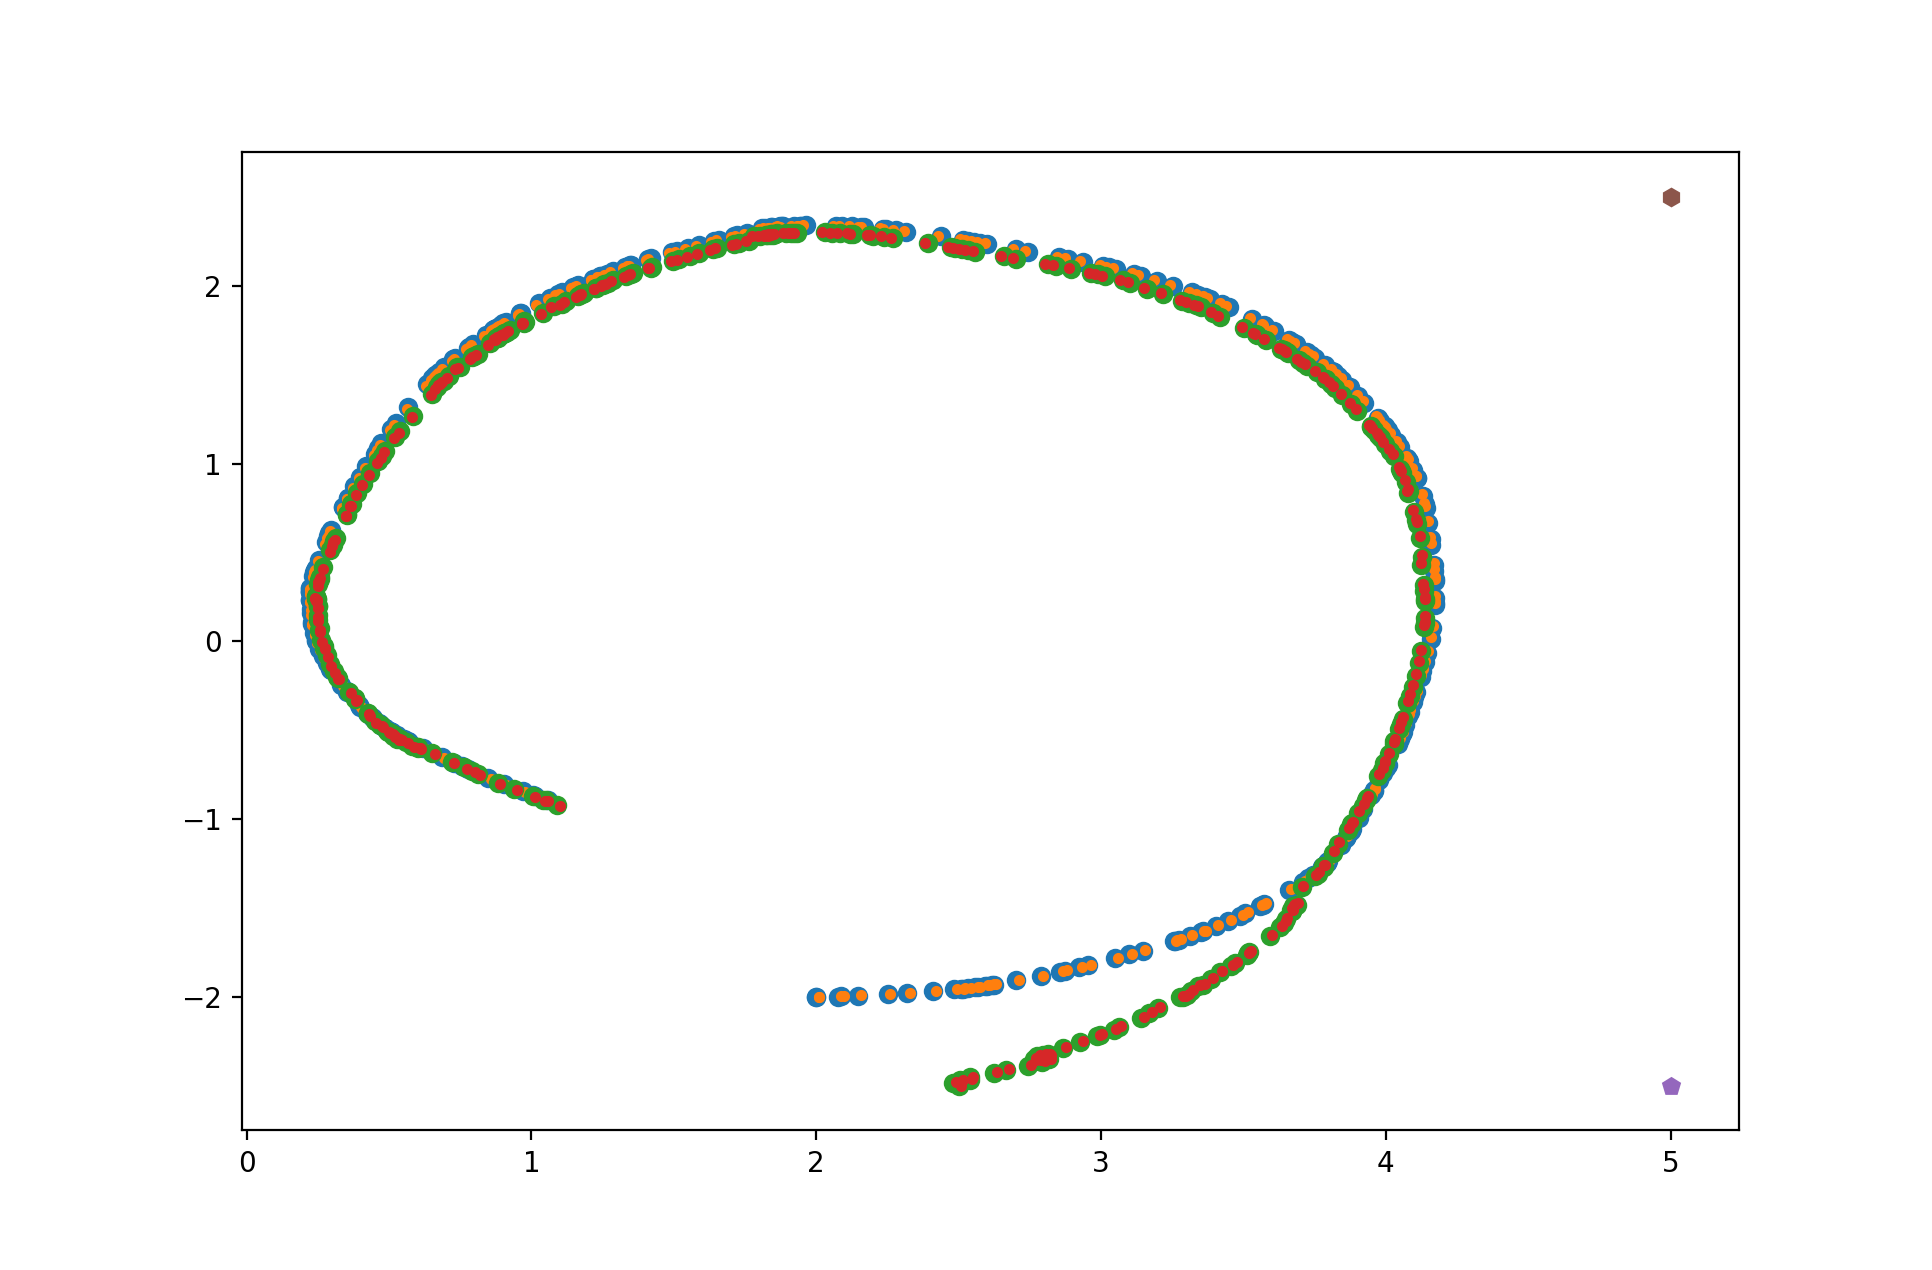

In [48]:
import matplotlib.pyplot as plt
L = 0.01
%matplotlib notebook
plt.figure()
plt.plot(x_t[:,0],x_t[:,1] ,'o',
     x_t[:,0]+np.dot(L, np.cos(x_t[:,2])), x_t[:,1]+np.dot(L, np.sin(x_t[:,2])) ,'.',
     x_e_t[:,0],   x_e_t[:,1] ,'o',
     x_e_t[:,0]+np.dot(L, np.cos(x_e_t[:,2])),   x_e_t[:,1]+np.dot(L, np.sin(x_e_t[:,2])) ,'.' ,
     xb1, yb1 ,'p', xb2, yb2, 'h')
#legend(   'xy',          'dir', 'xy_e',          'dir_e', 'Pole 1',  'Pole 2' ),
plt.show()

## 2. Implementation considering only angle or distance measure
We need to change some things...

### Only angle measure

Reset the values needed to retake the simulation. We set an expected initial angle quite far from the real one.

In [31]:
x = np.array([2, -2, 0]) # real initial state
x_e = np.array([2.5, -2.5, 0.8]) # expected initial state, different angle
P = np.eye(3)*1e-3 # covariance robot belief from prediction update
x_t = np.zeros([N, 3])
x_e_t = np.zeros([N, 3])

And then back to the simulation

In [32]:
for i in range(0, N):
    # record the evolution of the states
    x_t[i] = np.copy(x)
    x_e_t[i] = np.copy(x_e)
    
    # simulation of the robot
    v = u_t[0, i]
    omega = u_t[1, i]
    TSPAN = [0, dt]
    sol = solve_ivp(lambda t, y: F(t,y,u_t[:,i]), TSPAN, x)

    x = sol.y[:,-1]
    xr = x[0]
    yr = x[1]
    theta_r = x[2]

    # update of the extimation of the state of the robot X(k+1) = f(X(k),U)
    xr_e = x_e[0] 
    yr_e = x_e[1] 
    theta_r_e = x_e[2]

    xr_e = xr_e + v * cos(theta_r_e + omega * dt / 2) * dt 
    yr_e = yr_e + v * sin(theta_r_e + omega * dt / 2) * dt 
    theta_r_e = theta_r_e + omega * dt

    x_e = np.array([xr_e, yr_e, theta_r_e])

    # calculate grad_f_X=df/dX 
    grad_f_X = np.array([[1, 0, -v*dt*sin(theta_r_e+omega*dt/2)],
                         [0, 1, v*dt*cos(theta_r_e+omega*dt/2)],
                         [0, 0, 1]])

    # calculate grad_f_U=df/dU
    grad_f_U = np.array([[cos(theta_r_e+omega*dt/2)*dt, -v*dt*0.5*sin(theta_r_e+omega*dt/2)],
                         [sin(theta_r_e+omega*dt/2)*dt, v*dt*0.5*cos(theta_r_e+omega*dt/2)],
                         [0, 1]])

    # update covariance
    P = np.dot(grad_f_X, np.dot(P, grad_f_X.T)) + np.dot(grad_f_U, np.dot(Q, grad_f_U.T))

    # counter to change from one beacon to the other
    p_count += 1

    if p_count==100:
        p_count = 0 
    
    # covariance matrix of the measures noise
    R = np.array([[0, 0],
                  [0, sdv_ang**2]])
     
    if p_count <= 50: # beacon 1
        # simulation of the observed measures
        theta_p = atan2(yb1 - yr, xb1 - xr) - theta_r
        theta_p_measured = theta_p + np.random.normal(0,1) * sdv_ang

        # expected values for the measures taking into account the state of the robot z = h(X)
        theta_p_e = atan2(yb1 - yr_e, xb1 - xr_e) - theta_r_e
         
    else: # beacon 2
        # simulation of the observed measures
        theta_p = atan2(yb2 - yr, xb2 - xr) - theta_r
        theta_p_measured = theta_p + np.random.normal(0,1) * sdv_ang

        # expected values for the measures taking into account the state of the robot z = h(X)
        theta_p_e = atan2(yb2 - yr_e, xb2 - xr_e) - theta_r_e
        
    # calculation of dH/dX
    grad_h_X  = np.array([[1, 0, 0],
                          [0, 1, -1]])
    
    z = np.array([0, theta_p_measured])
    z_e = np.array([0, theta_p_e])

    # Kalman gain
    k = np.dot(P,np.dot(grad_h_X.T, np.linalg.inv(np.dot(grad_h_X, np.dot(P, grad_h_X.T)) + R)));

    # covariance update
    P = np.dot(np.eye(3) - np.dot(k, grad_h_X), P)

    # update expected state
    x_e = x_e + np.dot(k, np.transpose(z - z_e))

Let's print the results also in this case

<IPython.core.display.Javascript object>


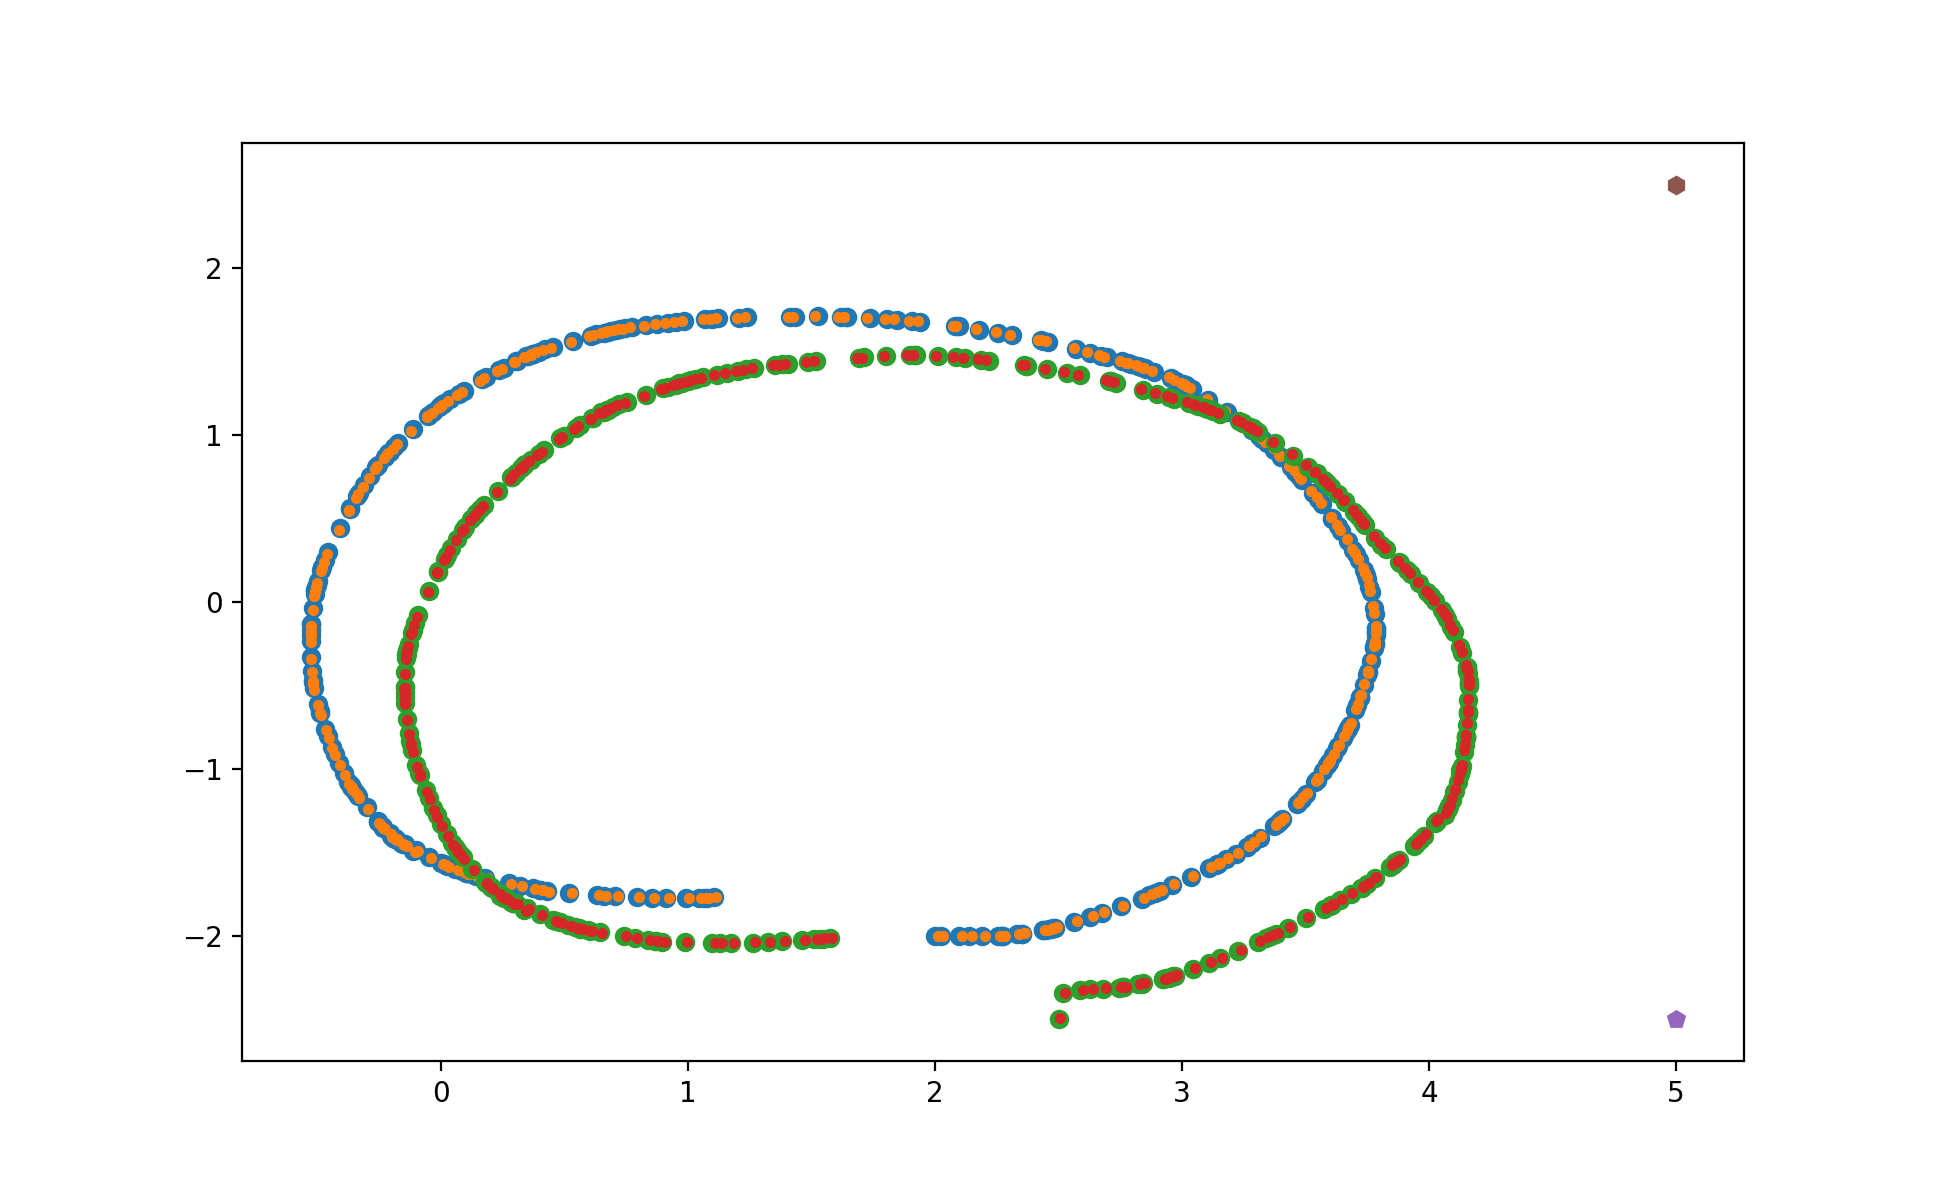

In [33]:
L = 0.01
%matplotlib notebook
plt.figure()
plt.plot(x_t[:,0],x_t[:,1] ,'o',
     x_t[:,0]+np.dot(L, np.cos(x_t[:,2])), x_t[:,1]+np.dot(L, np.sin(x_t[:,2])) ,'.',
     x_e_t[:,0],   x_e_t[:,1] ,'o',
     x_e_t[:,0]+np.dot(L, np.cos(x_e_t[:,2])),   x_e_t[:,1]+np.dot(L, np.sin(x_e_t[:,2])) ,'.' ,
     xb1, yb1 ,'p', xb2, yb2, 'h')
#legend(   'xy',          'dir', 'xy_e',          'dir_e', 'Pole 1',  'Pole 2' ),
plt.show()

As one could have imagined the expected value after little time tracks perfectly the angle but does not recover from being in the wrong position.

### Only distance measure

Again, we reset the simulation

In [28]:
x = np.array([2, -2, 0]) # real initial state
x_e = np.array([2.5, -2.5, 0.8]) # expected initial state, different angle
P = np.eye(3)*1e-3 # covariance robot belief from prediction update
x_t = np.zeros([N, 3])
x_e_t = np.zeros([N, 3])

Simulate

In [29]:
for i in range(0, N):
    # record the evolution of the states
    x_t[i] = np.copy(x)
    x_e_t[i] = np.copy(x_e)
    
    # simulation of the robot
    v = u_t[0, i]
    omega = u_t[1, i]
    TSPAN = [0, dt]
    sol = solve_ivp(lambda t, y: F(t,y,u_t[:,i]), TSPAN, x)

    x = sol.y[:,-1]
    xr = x[0]
    yr = x[1]
    theta_r = x[2]

    # update of the extimation of the state of the robot X(k+1) = f(X(k),U)
    xr_e = x_e[0] 
    yr_e = x_e[1] 
    theta_r_e = x_e[2]

    xr_e = xr_e + v * cos(theta_r_e + omega * dt / 2) * dt 
    yr_e = yr_e + v * sin(theta_r_e + omega * dt / 2) * dt 
    theta_r_e = theta_r_e + omega * dt

    x_e = np.array([xr_e, yr_e, theta_r_e])

    # calculate grad_f_X=df/dX 
    grad_f_X = np.array([[1, 0, -v*dt*sin(theta_r_e+omega*dt/2)],
                         [0, 1, v*dt*cos(theta_r_e+omega*dt/2)],
                         [0, 0, 1]])

    # calculate grad_f_U=df/dU
    grad_f_U = np.array([[cos(theta_r_e+omega*dt/2)*dt, -v*dt*0.5*sin(theta_r_e+omega*dt/2)],
                         [sin(theta_r_e+omega*dt/2)*dt, v*dt*0.5*cos(theta_r_e+omega*dt/2)],
                         [0, 1]])

    # update covariance
    P = np.dot(grad_f_X, np.dot(P, grad_f_X.T)) + np.dot(grad_f_U, np.dot(Q, grad_f_U.T))

    # counter to change from one beacon to the other
    p_count += 1

    if p_count==100:
        p_count=0 

    if p_count <= 50: # beacon 1
        # simulation of the observed measures
        distp = sqrt((xb1 - xr)**2 + (yb1 - yr)**2)
        distp_measured = distp + np.random.normal(0,1) * sdv_dist_1m * distp
        z = np.array([distp_measured, 0])

        # expected values for the measures taking into account the state of the robot z = h(X)
        distp_e = sqrt((xb1 - xr_e)**2 + (yb1 - yr_e)**2)
        z_e = np.array([distp_e, 0])

        # covariance matrix of the measures noise
        R = np.array([[(distp_e*sdv_dist_1m)**2, 0],
                      [0, 0]])

        # calculation of dH/dX
        grad_h_X  = np.array([[-(xb1-xr_e)/distp_e, -(yb1-yr_e)/distp_e, 0],
                              [(yb1-yr_e)/(distp_e**2), -(xb1-xr_e)/(distp_e**2), 0]])           
    else: # beacon 2
        # simulation of the observed measures
        distp = sqrt((xb2 - xr)**2 + (yb2 - yr)**2)
        distp_measured = distp + np.random.normal(0,1) * sdv_dist_1m * distp
        z = np.array([distp_measured, 0])

        # expected values for the measures taking into account the state of the robot z = h(X)
        distp_e = sqrt((xb2 - xr_e)**2 + (yb2 - yr_e)**2)
        z_e = np.array([distp_e, 0])

        # covariance matrix of the measures noise
        R = np.array([[(distp_e*sdv_dist_1m)**2, 0],
                      [0, 0]])

        # calculation of dH/dX
        grad_h_X  = np.array([[-(xb2-xr_e)/distp_e, -(yb2-yr_e)/distp_e, 0],
                              [(yb2-yr_e)/(distp_e**2), -(xb2-xr_e)/(distp_e**2), 0]])


    # Kalman gain
    k = np.dot(P,np.dot(grad_h_X.T, np.linalg.inv(np.dot(grad_h_X, np.dot(P, grad_h_X.T)) + R)));

    # covariance update
    P = np.dot(np.eye(3) - np.dot(k, grad_h_X), P)

    # update expected state
    x_e = x_e + np.dot(k, np.transpose(z - z_e))

Print the result

<IPython.core.display.Javascript object>


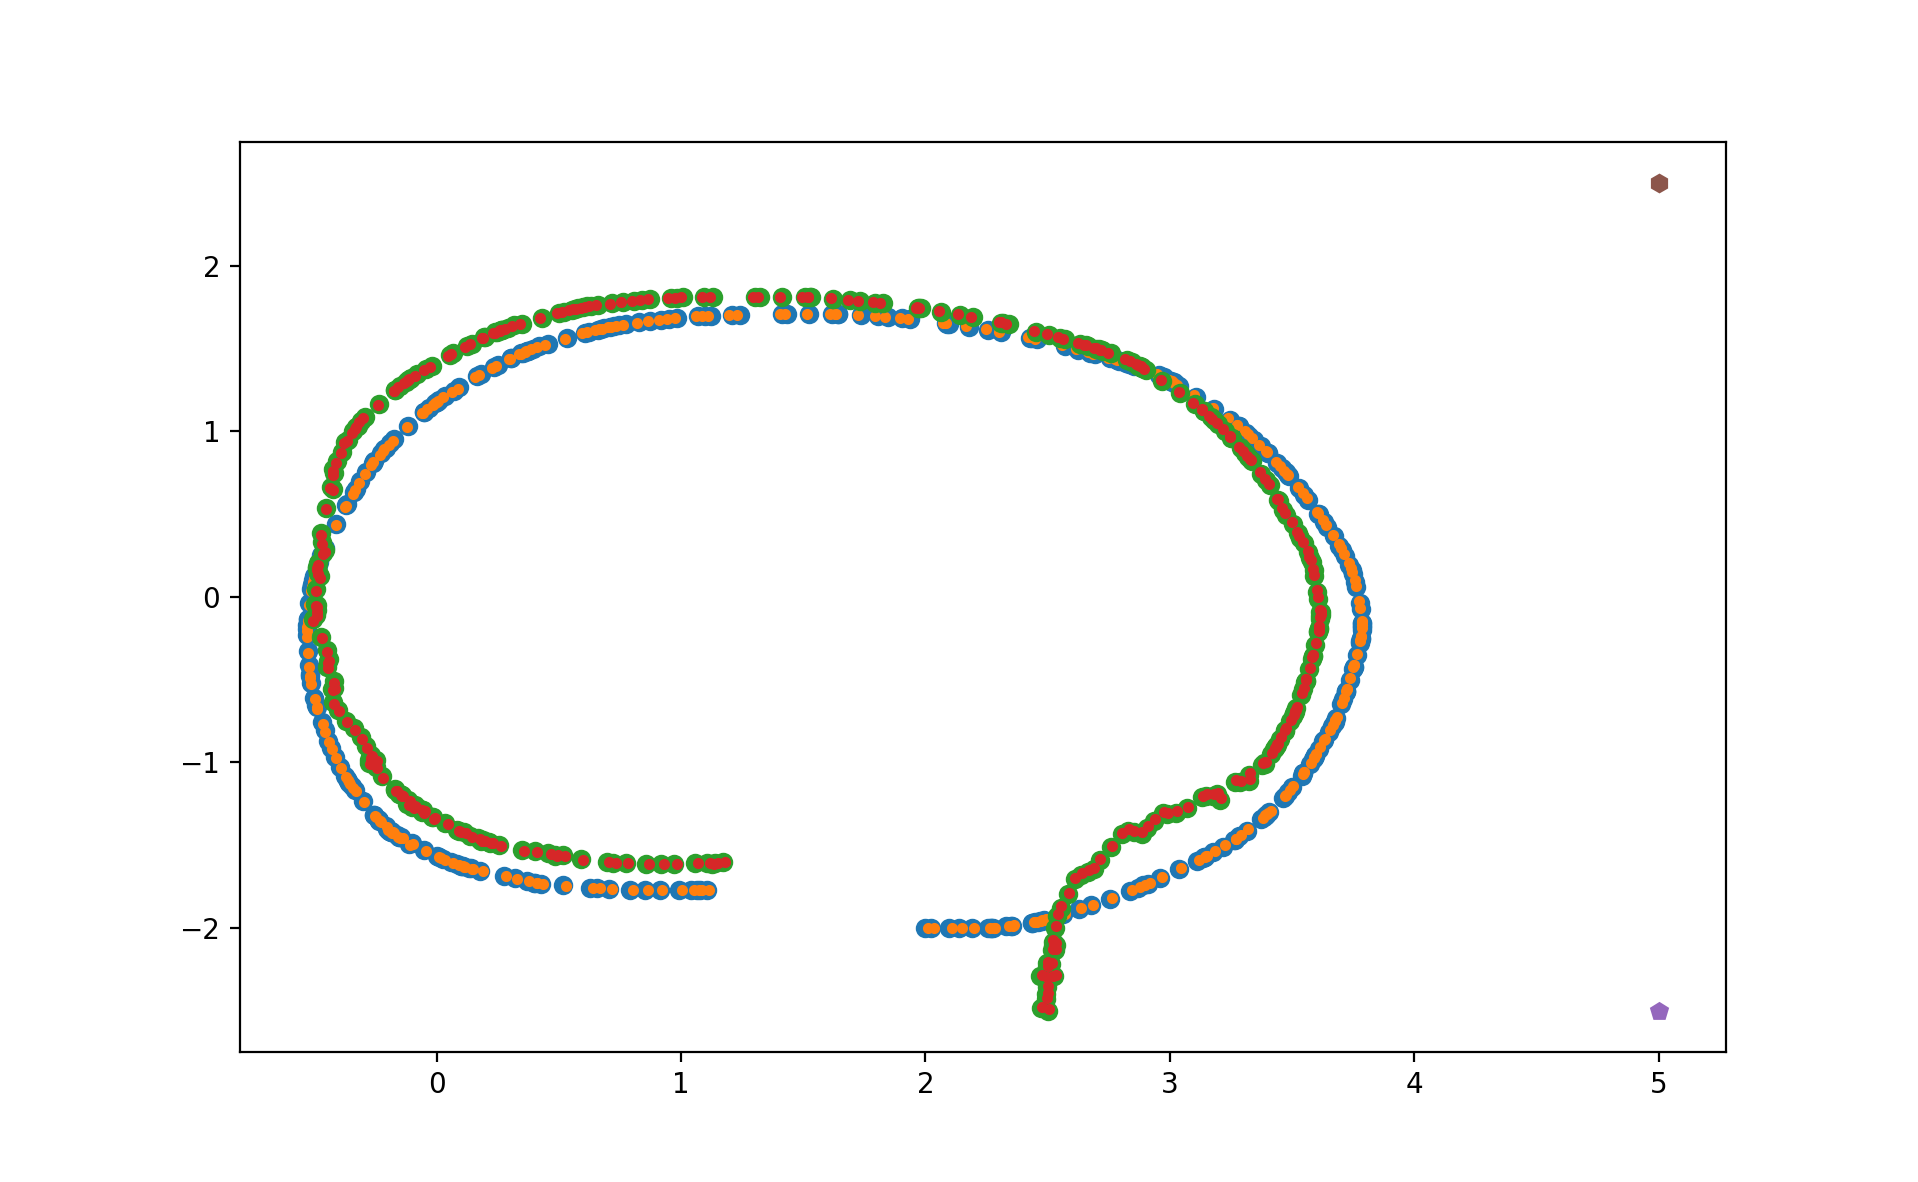

In [30]:
L = 0.01
%matplotlib notebook
plt.figure()
plt.plot(x_t[:,0],x_t[:,1] ,'o',
     x_t[:,0]+np.dot(L, np.cos(x_t[:,2])), x_t[:,1]+np.dot(L, np.sin(x_t[:,2])) ,'.',
     x_e_t[:,0],   x_e_t[:,1] ,'o',
     x_e_t[:,0]+np.dot(L, np.cos(x_e_t[:,2])),   x_e_t[:,1]+np.dot(L, np.sin(x_e_t[:,2])) ,'.' ,
     xb1, yb1 ,'p', xb2, yb2, 'h')
#legend(   'xy',          'dir', 'xy_e',          'dir_e', 'Pole 1',  'Pole 2' ),
plt.show()

## 3. Four beacons simultaneously
Now we are pretending to use a omnidirectional camera. This gives us the ability to observe all four beacons at the same moment. We do some changes to the simulation...

First of all we set the positions of the four beacons. For doing so we define an array of objects of class "Beacon".

In [23]:
class Beacon:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
b = [Beacon(5, -2.5), Beacon(5, 2.5), Beacon(-5, 2.5), Beacon(-5, -2.5)]

Then we reset the variables for the simulation

In [24]:
x = np.array([2, -2, 0]) # real initial state
x_e = np.array([2.5, -2.5, 0]) # expected initial state
P = np.eye(3)*1e-3 # covariance robot belief from prediction update
x_t = np.zeros([N, 3])
x_e_t = np.zeros([N, 3])

Apparently we need

In [25]:
def wraptopi(x):
    return ( x + np.pi) % (2 * np.pi ) - np.pi

And simulate. Basically the only difference is that we loop on the update phase for each beacon.

In [26]:
for i in range(0, N):
    # record the evolution of the states
    x_t[i] = np.copy(x)
    x_e_t[i] = np.copy(x_e)
    
    # simulation of the robot
    v = u_t[0, i]
    omega = u_t[1, i]
    TSPAN = [0, dt]
    sol = solve_ivp(lambda t, y: F(t,y,u_t[:,i]), TSPAN, x)

    x = sol.y[:,-1]
    xr = x[0]
    yr = x[1]
    x[2] = wraptopi(x[2])
    theta_r = x[2]

    # update of the extimation of the state of the robot X(k+1) = f(X(k),U)
    xr_e = x_e[0] 
    yr_e = x_e[1] 
    theta_r_e = x_e[2]

    xr_e = xr_e + v * cos(theta_r_e + omega * dt / 2) * dt 
    yr_e = yr_e + v * sin(theta_r_e + omega * dt / 2) * dt 
    theta_r_e = wraptopi(theta_r_e + omega * dt)
    
    x_e = np.array([xr_e, yr_e, theta_r_e])

    # calculate grad_f_X=df/dX 
    grad_f_X = np.array([[1, 0, -v*dt*sin(theta_r_e+omega*dt/2)],
                         [0, 1, v*dt*cos(theta_r_e+omega*dt/2)],
                         [0, 0, 1]])

    # calculate grad_f_U=df/dU
    grad_f_U = np.array([[cos(theta_r_e+omega*dt/2)*dt, -v*dt*0.5*sin(theta_r_e+omega*dt/2)],
                         [sin(theta_r_e+omega*dt/2)*dt, v*dt*0.5*cos(theta_r_e+omega*dt/2)],
                         [0, 1]])

    # update covariance
    P = np.dot(grad_f_X, np.dot(P, grad_f_X.T)) + np.dot(grad_f_U, np.dot(Q, grad_f_U.T))

    for bi in range(0, 4):
        
        # simulation of the observed measures
        distp = sqrt((b[bi].x - xr)**2 + (b[bi].y - yr)**2)
        distp_measured = distp + np.random.normal(0,1) * sdv_dist_1m * distp
        theta_p = wraptopi(atan2(b[bi].y - yr, b[bi].x - xr) - theta_r)
        theta_p_measured = wraptopi(theta_p + np.random.normal(0,1) * sdv_ang)
        z = np.array([distp_measured, theta_p_measured])

        # expected values for the measures taking into account the state of the robot z = h(X)
        distp_e = sqrt((b[bi].x - xr_e)**2 + (b[bi].y - yr_e)**2)
        theta_p_e = wraptopi(atan2(b[bi].y - yr_e, b[bi].x - xr_e) - theta_r_e)
        z_e = [distp_e, theta_p_e]

        # covariance matrix of the measures noise
        R = np.array([[(distp_e*sdv_dist_1m)**2, 0],
                      [0, sdv_ang**2]])

        # calculation of dH/dX
        grad_h_X  = np.array([[-(b[bi].x-xr_e)/distp_e, -(b[bi].y-yr_e)/distp_e, 0],
                              [(b[bi].y-yr_e)/(distp_e**2), -(b[bi].x-xr_e)/(distp_e**2), -1]])           

        # Kalman gain
        k = np.dot(P,np.dot(grad_h_X.T, np.linalg.inv(np.dot(grad_h_X, np.dot(P, grad_h_X.T)) + R)));

        # covariance update
        P = np.dot(np.eye(3) - np.dot(k, grad_h_X), P)

        # update expected state
        diff_z = z - z_e
        diff_z[1] = wraptopi(diff_z[1])
        x_e = x_e + np.dot(k, np.transpose(diff_z))
        x_e[2] = wraptopi(x_e[2])
        
        xr_e = x_e[0]
        yr_e = x_e[1]
        theta_r_e = x_e[2]

Print the results

<IPython.core.display.Javascript object>


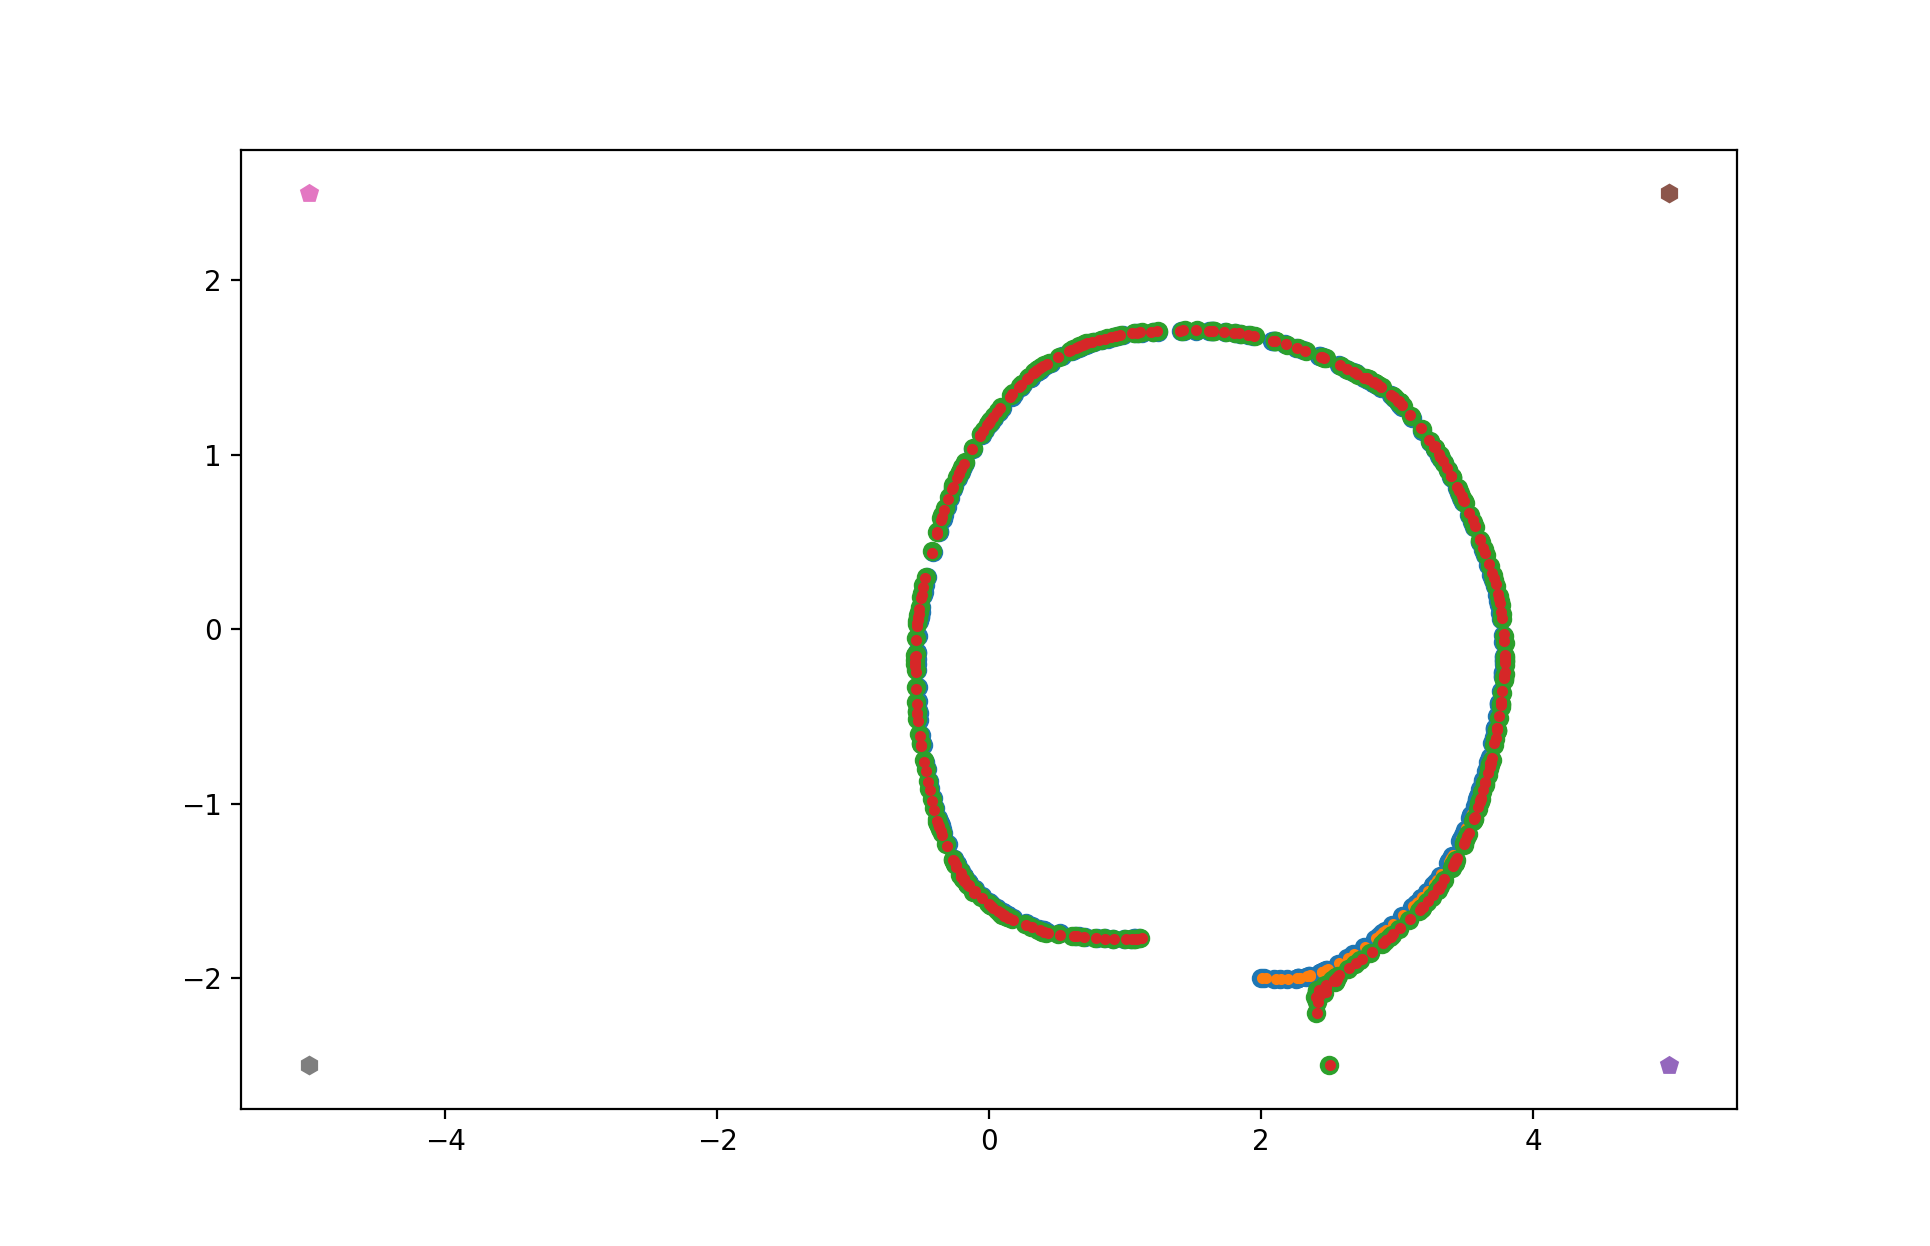

In [27]:
L = 0.01
%matplotlib notebook
plt.figure()
plt.plot(x_t[:,0],x_t[:,1] ,'o',
         x_t[:,0]+np.dot(L, np.cos(x_t[:,2])), x_t[:,1]+np.dot(L, np.sin(x_t[:,2])) ,'.',
         x_e_t[:,0],   x_e_t[:,1] ,'o',
         x_e_t[:,0]+np.dot(L, np.cos(x_e_t[:,2])),   x_e_t[:,1]+np.dot(L, np.sin(x_e_t[:,2])) ,'.' ,
         b[0].x, b[0].y ,'p', b[1].x, b[1].y, 'h',
         b[2].x, b[2].y ,'p', b[3].x, b[3].y, 'h')
#legend(   'xy',          'dir', 'xy_e',          'dir_e', 'Pole 1',  'Pole 2' ),
plt.show()

## 4. Four beacons: only angle or distance
Content

## 5. Observations of the beacons in coordinates of the robot referential frame
Content